### Data Preparation

In [255]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [256]:
# Read files
made_shots = pd.read_csv("./data/player_metrics_open.csv")
missed_shots = pd.read_csv("./data/player_metrics_defended.csv")
position_info = pd.read_csv("./data/additional_info.csv")

In [257]:
position_info = position_info[["name", "position"]]

In [258]:
made_shots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pid     189 non-null    int64  
 1   fnm     189 non-null    object 
 2   lnm     189 non-null    object 
 3   hght    173 non-null    float64
 4   n       189 non-null    int64  
 5   bx      188 non-null    float64
 6   by      188 non-null    float64
 7   bz      188 non-null    float64
 8   rt      188 non-null    float64
 9   rx      188 non-null    float64
 10  ry      188 non-null    float64
 11  rz      188 non-null    float64
 12  rv      188 non-null    float64
 13  rvx     188 non-null    float64
 14  rvy     188 non-null    float64
 15  rvz     188 non-null    float64
 16  mnv     188 non-null    float64
 17  mnvt    180 non-null    float64
 18  mnvx    180 non-null    float64
 19  mnvy    180 non-null    float64
 20  mnvz    180 non-null    float64
 21  mxv     188 non-null    float64
 22  mx

In [259]:
missed_shots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pid     189 non-null    int64  
 1   fnm     189 non-null    object 
 2   lnm     189 non-null    object 
 3   hght    173 non-null    float64
 4   n       189 non-null    int64  
 5   bx      177 non-null    float64
 6   by      177 non-null    float64
 7   bz      177 non-null    float64
 8   rt      177 non-null    float64
 9   rx      177 non-null    float64
 10  ry      177 non-null    float64
 11  rz      177 non-null    float64
 12  rv      177 non-null    float64
 13  rvx     177 non-null    float64
 14  rvy     177 non-null    float64
 15  rvz     177 non-null    float64
 16  mnv     177 non-null    float64
 17  mnvt    168 non-null    float64
 18  mnvx    168 non-null    float64
 19  mnvy    168 non-null    float64
 20  mnvz    168 non-null    float64
 21  mxv     177 non-null    float64
 22  mx

In [260]:
made_shots["status"] = 1
missed_shots["status"] = 0

In [261]:
CONV_FACTOR = 0.0833333
made_shots["hght"] = made_shots["hght"] * CONV_FACTOR
missed_shots["hght"] = missed_shots["hght"] * CONV_FACTOR

In [262]:
made_shots["name"] = made_shots["fnm"] + " " + made_shots["lnm"]
made_shots = made_shots.drop(columns=["fnm", "lnm"])

missed_shots["name"] = missed_shots["fnm"] + " " + missed_shots["lnm"]
missed_shots = missed_shots.drop(columns=["fnm", "lnm"])

In [263]:
all_p = pd.concat([made_shots, missed_shots], axis=0)
selected = [
    "name",
    "hght",
    "bx",
    "by",
    "bz",
    "rt",
    "rx",
    "ry",
    "rz",
    "rv",
    "rvx",
    "rvy",
    "rvz",
    "ta1t",
    "ta1x",
    "ta1y",
    "ta1z",
    "pl",
    "plr",
    "status",
]
all_p = all_p[selected]
all_p.head()

,name,hght,bx,by,bz,rt,rx,ry,rz,rv,rvx,rvy,rvz,ta1t,ta1x,ta1y,ta1z,pl,plr,status
0,James Harden,6.416664,-0.129515,0.159514,3.354385,0.378,0.007704,0.013134,8.180299,14.422596,-7.145353,-0.470512,12.519338,0.081,-0.477440,-0.037729,4.200235,5.186692,1.073831,1
1,Damian Lillard,6.166664,-0.192844,-0.158115,2.917786,0.371,0.015377,-0.005018,7.653078,14.671368,-6.933572,-0.053912,12.929490,0.081,-0.540242,0.152878,3.771187,5.123032,1.080275,1
2,Trevor Ariza,6.666664,0.279411,0.142605,3.189609,0.439,-0.108531,0.004955,8.556270,14.881033,-6.697380,0.330577,13.284614,0.133,-0.319731,0.305477,4.218478,5.758962,1.069957,1
3,Wesley Matthews,6.333331,-0.664736,0.263333,3.188989,0.377,0.011191,-0.011425,7.446044,14.620723,-6.612055,0.108494,13.039727,0.098,-0.965872,0.391353,4.109148,4.825181,1.117165,1
4,Kyle Lowry,5.999998,-0.016750,0.262180,2.863618,0.395,0.005382,0.015878,7.853279,13.419374,-8.270247,0.298627,10.563779,0.077,-0.385468,0.610378,3.736080,5.500147,1.100958,1


In [264]:
# Retrieve positions and filter shooters only.
all_p = pd.merge(all_p, position_info, on="name")

In [265]:
all_p = all_p[
    all_p["position"].apply(lambda x: True if x.find("Guard") != -1 else False)
]
all_p.drop(columns=["name", "position"], inplace=True)
all_p.head()

,hght,bx,by,bz,rt,rx,ry,rz,rv,rvx,rvy,rvz,ta1t,ta1x,ta1y,ta1z,pl,plr,status
0,6.416664,-0.129515,0.159514,3.354385,0.378,0.007704,0.013134,8.180299,14.422596,-7.145353,-0.470512,12.519338,0.081,-0.477440,-0.037729,4.200235,5.186692,1.073831,1
1,6.416664,-0.022428,0.200926,3.322677,0.383,-0.020376,0.010732,8.535254,14.442496,-7.811150,-0.417388,12.140734,0.071,-0.408251,-0.004511,4.153640,5.569208,1.067707,0
2,6.166664,-0.192844,-0.158115,2.917786,0.371,0.015377,-0.005018,7.653078,14.671368,-6.933572,-0.053912,12.929490,0.081,-0.540242,0.152878,3.771187,5.123032,1.080275,1
3,6.166664,0.160019,-0.333957,3.006314,0.392,0.026035,-0.042586,7.991336,16.117911,-9.120067,0.643254,13.273947,0.088,-0.132928,-0.066252,4.052969,5.294511,1.059893,0
4,6.666664,0.279411,0.142605,3.189609,0.439,-0.108531,0.004955,8.556270,14.881033,-6.697380,0.330577,13.284614,0.133,-0.319731,0.305477,4.218478,5.758962,1.069957,1


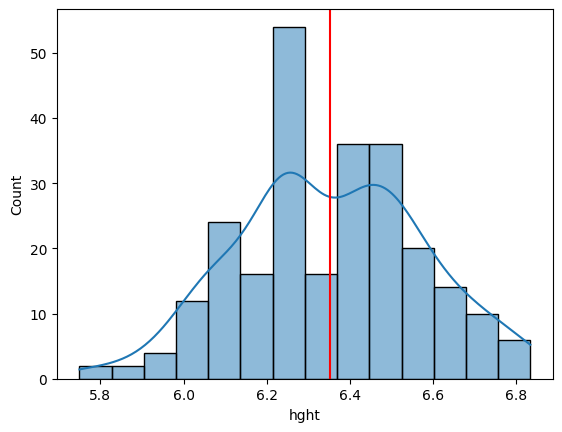

In [266]:
sns.histplot(data=all_p, x="hght", kde=True)
plt.axvline(x=all_p["hght"].mean(), color="red")

In [267]:
def calc_angle(y, y_0, t, v_0):
    height_diff = y - y_0
    g = -9.8
    sint = (height_diff + (0.5 * g * t**2)) / (t * v_0)
    return np.arcsin(sint) * (180 / np.pi)


all_p["raw_arc"] = made_shots.apply(
    lambda x: calc_angle(10, x["hght"], x["rt"], x["rv"]), axis=1
)

In [268]:
all_p.describe()

,hght,bx,by,bz,rt,rx,ry,rz,rv,rvx,rvy,rvz,ta1t,ta1x,ta1y,ta1z,pl,plr,status,raw_arc
count,252.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,254.000000,254.000000,254.000000,254.000000,268.000000,261.000000,268.000000,137.000000
mean,6.352511,0.142442,0.040309,3.135205,0.430797,-0.041056,-0.010369,8.333148,14.784885,-7.651967,0.011664,12.446915,0.116886,-0.400453,0.262919,4.247421,5.665287,1.107246,0.500000,28.360514
std,0.225176,0.630462,0.513233,0.410319,0.057823,0.113808,0.075240,0.587508,2.590201,2.144440,1.173119,2.422471,0.046166,0.465836,0.328832,0.470601,1.229214,0.085628,0.500935,7.718010
min,5.749998,-1.384817,-2.194413,1.308812,0.272000,-0.733733,-0.605164,6.787648,8.559975,-16.950415,-7.727016,7.358225,0.041000,-2.418228,-1.427374,3.156720,0.000000,1.019566,0.000000,8.562566
25%,6.249998,-0.265232,-0.177503,2.886822,0.385000,-0.059360,-0.032188,7.920840,13.545274,-8.746281,-0.489005,11.201108,0.077000,-0.667379,0.112997,3.952694,5.219478,1.066395,0.000000,23.538566
50%,6.333331,0.058235,0.083595,3.108333,0.428000,-0.020806,-0.011425,8.389865,14.421921,-7.695426,0.082478,12.286630,0.117000,-0.422547,0.284347,4.213117,5.757430,1.089419,0.500000,28.651847
75%,6.499997,0.462744,0.295127,3.324144,0.469000,0.005322,0.005379,8.712911,15.554446,-6.750653,0.562314,13.253243,0.139000,-0.175561,0.436789,4.506643,6.224100,1.116879,1.000000,32.750018
max,6.833331,2.740010,1.831524,4.727747,0.598000,0.341767,0.480878,10.517372,29.970071,5.695147,5.123171,25.030400,0.301000,1.685549,1.447804,6.474448,9.441792,1.877879,1.000000,58.817322


<Axes: xlabel='status', ylabel='plr'>

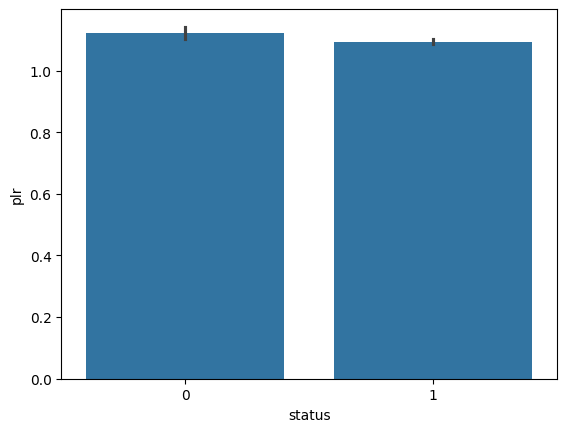

In [269]:
sns.barplot(data=all_p, x="status", y="plr")

<Axes: xlabel='status', ylabel='rvz'>

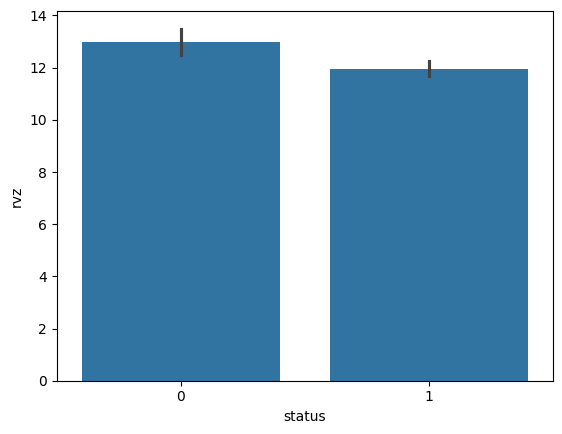

In [270]:
sns.barplot(data=all_p, x="status", y="rvz")

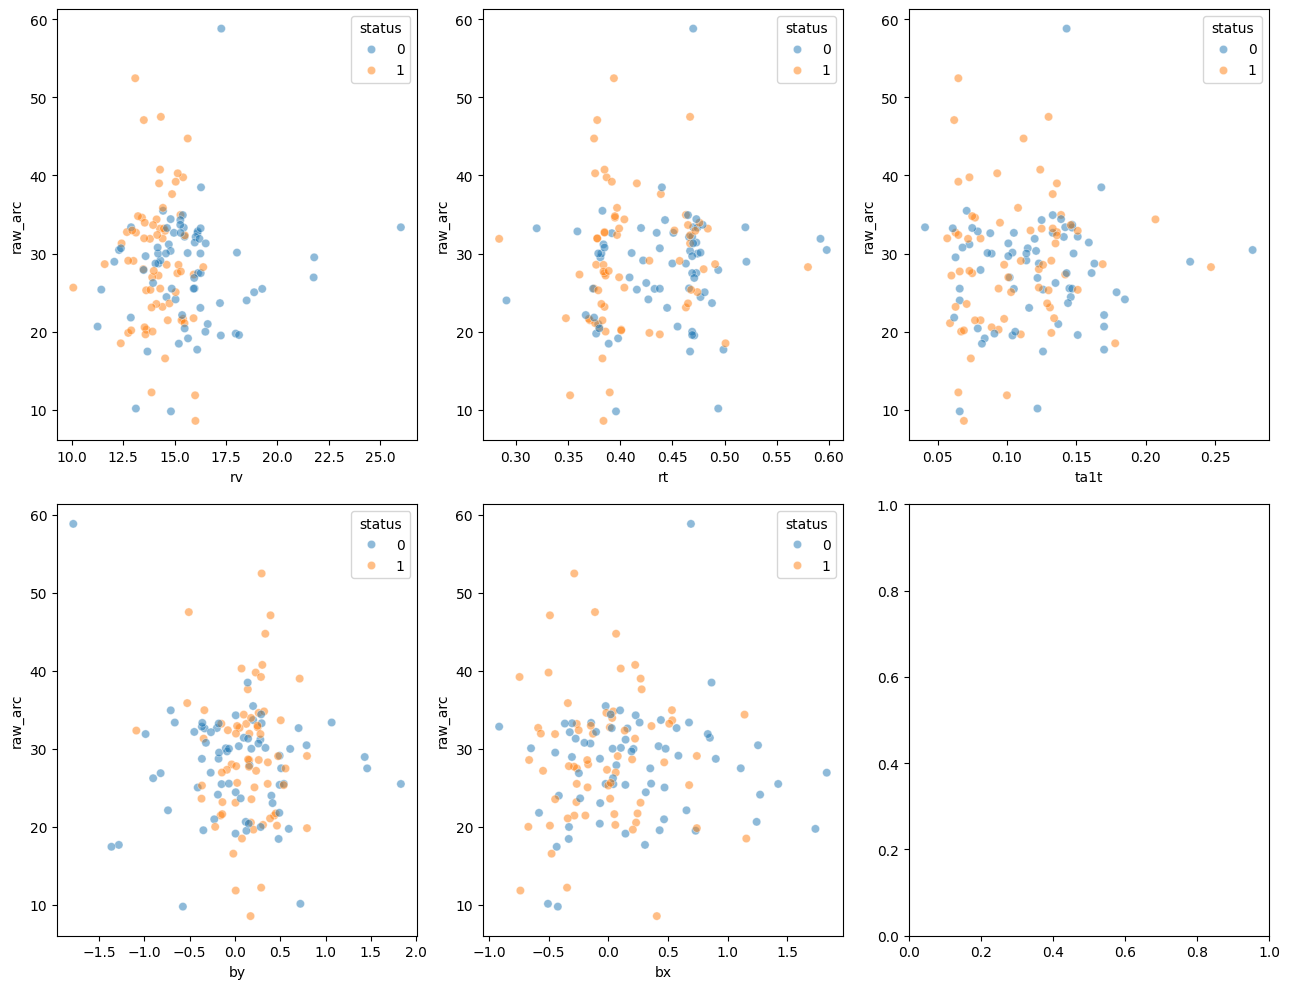

In [271]:
fig, ax = plt.subplots(2, 3, figsize=(13, 10))
sns.scatterplot(data=all_p, x="rv", y="raw_arc", hue="status", alpha=0.5, ax=ax[0, 0])
sns.scatterplot(data=all_p, x="rt", y="raw_arc", hue="status", alpha=0.5, ax=ax[0, 1])
sns.scatterplot(data=all_p, x="by", y="raw_arc", hue="status", alpha=0.5, ax=ax[1, 0])
sns.scatterplot(data=all_p, x="bx", y="raw_arc", hue="status", alpha=0.5, ax=ax[1, 1])
sns.scatterplot(
    data=all_p, x="ta1t", y="raw_arc", hue="status", alpha=0.5, ax=ax[0, 2]
)  # shot preparation
fig.tight_layout()

In [272]:
all_p.corr()

,hght,bx,by,bz,rt,rx,ry,rz,rv,rvx,rvy,rvz,ta1t,ta1x,ta1y,ta1z,pl,plr,status,raw_arc
hght,1.000000e+00,-0.173441,-0.028044,0.300513,-0.099934,-0.095149,0.025038,0.408280,0.038207,0.080392,0.025576,0.084342,-0.224464,-0.157091,0.008122,0.222804,0.029727,-0.179367,2.818119e-17,0.078764
bx,-1.734410e-01,1.000000,-0.071657,-0.165754,0.403071,0.048938,0.082552,0.164699,0.159374,-0.289629,-0.211295,0.048480,0.625052,0.818889,-0.062571,0.254280,0.332359,0.056292,-1.858607e-01,0.013607
by,-2.804407e-02,-0.071657,1.000000,0.088345,-0.118915,0.296436,0.213795,-0.088322,-0.268322,0.125224,-0.319734,-0.265947,-0.042193,-0.030296,0.781157,0.034777,-0.197292,-0.054646,1.010704e-01,-0.089084
bz,3.005130e-01,-0.165754,0.088345,1.000000,-0.051223,0.071223,-0.083836,0.103135,0.008221,-0.072028,0.050395,-0.020060,-0.227471,0.027825,-0.082876,0.337335,-0.359867,0.279862,-8.534061e-02,0.091759
rt,-9.993400e-02,0.403071,-0.118915,-0.051223,1.000000,-0.114920,-0.109967,0.440299,0.017725,-0.352637,-0.025364,-0.148129,0.626159,0.150215,-0.038959,0.076940,0.693576,0.520973,-2.666854e-01,0.072554
rx,-9.514897e-02,0.048938,0.296436,0.071223,-0.114920,1.000000,-0.032298,-0.032388,0.073513,-0.282512,0.016010,-0.026501,-0.202982,0.292461,0.148290,-0.182706,-0.072815,0.055214,2.878132e-02,-0.045805
ry,2.503823e-02,0.082552,0.213795,-0.083836,-0.109967,-0.032298,1.000000,-0.021746,-0.277914,0.261389,-0.289831,-0.252123,0.036446,0.030014,0.330926,-0.008330,-0.018340,-0.109866,2.141681e-02,-0.054294
rz,4.082804e-01,0.164699,-0.088322,0.103135,0.440299,-0.032388,-0.021746,1.000000,0.072602,-0.437411,0.055836,-0.123888,0.068525,0.152210,-0.022059,0.362882,0.724236,-0.067171,-3.852097e-01,-0.036688
rv,3.820738e-02,0.159374,-0.268322,0.008221,0.017725,0.073513,-0.277914,0.072602,1.000000,-0.445786,0.087346,0.926848,-0.076023,0.176481,-0.261326,-0.044585,0.156474,0.122031,-2.877991e-01,-0.001250
rvx,8.039160e-02,-0.289629,0.125224,-0.072028,-0.352637,-0.282512,0.261389,-0.437411,-0.445786,1.000000,-0.019644,-0.124113,0.021314,-0.411321,0.096695,-0.114670,-0.385501,-0.100561,2.251290e-01,-0.010303


In [273]:
all_p.info()

<class 'pandas.core.frame.DataFrame'>
Index: 268 entries, 0 to 367
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   hght     252 non-null    float64
 1   bx       261 non-null    float64
 2   by       261 non-null    float64
 3   bz       261 non-null    float64
 4   rt       261 non-null    float64
 5   rx       261 non-null    float64
 6   ry       261 non-null    float64
 7   rz       261 non-null    float64
 8   rv       261 non-null    float64
 9   rvx      261 non-null    float64
 10  rvy      261 non-null    float64
 11  rvz      261 non-null    float64
 12  ta1t     254 non-null    float64
 13  ta1x     254 non-null    float64
 14  ta1y     254 non-null    float64
 15  ta1z     254 non-null    float64
 16  pl       268 non-null    float64
 17  plr      261 non-null    float64
 18  status   268 non-null    int64  
 19  raw_arc  137 non-null    float64
dtypes: float64(19), int64(1)
memory usage: 44.0 KB


do plots ...


### Preprocessing

In [296]:
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

# from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif

In [297]:
all_p.drop_duplicates()

,hght,bx,by,bz,rt,rx,ry,rz,rv,rvx,rvy,rvz,ta1t,ta1x,ta1y,ta1z,pl,plr,status,raw_arc
0,6.416664,-0.129515,0.159514,3.354385,0.378,0.007704,0.013134,8.180299,14.422596,-7.145353,-0.470512,12.519338,0.081,-0.477440,-0.037729,4.200235,5.186692,1.073831,1,31.928418
1,6.416664,-0.022428,0.200926,3.322677,0.383,-0.020376,0.010732,8.535254,14.442496,-7.811150,-0.417388,12.140734,0.071,-0.408251,-0.004511,4.153640,5.569208,1.067707,0,35.475226
2,6.166664,-0.192844,-0.158115,2.917786,0.371,0.015377,-0.005018,7.653078,14.671368,-6.933572,-0.053912,12.929490,0.081,-0.540242,0.152878,3.771187,5.123032,1.080275,1,21.450365
3,6.166664,0.160019,-0.333957,3.006314,0.392,0.026035,-0.042586,7.991336,16.117911,-9.120067,0.643254,13.273947,0.088,-0.132928,-0.066252,4.052969,5.294511,1.059893,0,32.606489
4,6.666664,0.279411,0.142605,3.189609,0.439,-0.108531,0.004955,8.556270,14.881033,-6.697380,0.330577,13.284614,0.133,-0.319731,0.305477,4.218478,5.758962,1.069957,1,37.617904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,6.249998,1.766881,-1.398022,1.991248,0.511,-0.733733,0.037351,7.819601,13.480980,-6.750653,0.202463,11.667241,NaN,NaN,NaN,NaN,6.747443,1.037662,0,NaN
364,6.583331,-0.586282,-0.012192,3.261287,0.387,-0.033434,-0.052607,8.499812,14.281961,-6.401334,0.953329,12.731398,0.069,-0.866825,0.009973,4.066162,5.558832,1.055253,1,NaN
365,6.583331,1.559400,0.988611,3.654317,0.519,0.142942,0.046699,10.096468,16.601861,-10.063614,-0.076595,13.203772,NaN,NaN,NaN,NaN,7.479449,1.122544,0,NaN
366,6.416664,-0.476678,0.131646,3.301677,0.389,-0.023809,-0.004602,8.266374,13.911234,-7.695426,-0.135239,11.588121,0.062,-0.718425,0.253908,4.273512,5.339680,1.070683,1,NaN


In [298]:
X = all_p.drop(columns="status")
y = all_p["status"]

In [299]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [300]:
general_pipeline = Pipeline(
    [("scaler", RobustScaler()), ("imputer", KNNImputer(n_neighbors=15))]
)

In [301]:
# create list of all models we will use
models = [
    {"name": "LogisticRegression", "model": LogisticRegression()},
    {"name": "RandomForest", "model": RandomForestClassifier()},
    {"name": "SVM", "model": SVC()},
]

In [302]:
def find_best_features(m):
    result = []
    for i in range(0, len(models)):

        for j in range(1, X.shape[1]):

            pipeline = Pipeline(
                [
                    ("preprocessing", general_pipeline),
                    ("feature_selection", SelectKBest(f_classif, k=j)),
                    ("model", m[i]["model"]),
                ]
            )


            pipeline.fit(X_train, y_train)

            score = pipeline.score(X_test, y_test)


            result.append({"name": m[i]["name"], "n_features": j, "score": score})
    return result



print(find_best_features(models))

[{'name': 'LogisticRegression', 'n_features': 1, 'score': 0.5925925925925926}, {'name': 'LogisticRegression', 'n_features': 2, 'score': 0.7037037037037037}, {'name': 'LogisticRegression', 'n_features': 3, 'score': 0.7037037037037037}, {'name': 'LogisticRegression', 'n_features': 4, 'score': 0.7222222222222222}, {'name': 'LogisticRegression', 'n_features': 5, 'score': 0.6851851851851852}, {'name': 'LogisticRegression', 'n_features': 6, 'score': 0.6666666666666666}, {'name': 'LogisticRegression', 'n_features': 7, 'score': 0.7222222222222222}, {'name': 'LogisticRegression', 'n_features': 8, 'score': 0.7222222222222222}, {'name': 'LogisticRegression', 'n_features': 9, 'score': 0.7222222222222222}, {'name': 'LogisticRegression', 'n_features': 10, 'score': 0.7222222222222222}, {'name': 'LogisticRegression', 'n_features': 11, 'score': 0.7777777777777778}, {'name': 'LogisticRegression', 'n_features': 12, 'score': 0.7962962962962963}, {'name': 'LogisticRegression', 'n_features': 13, 'score': 0.

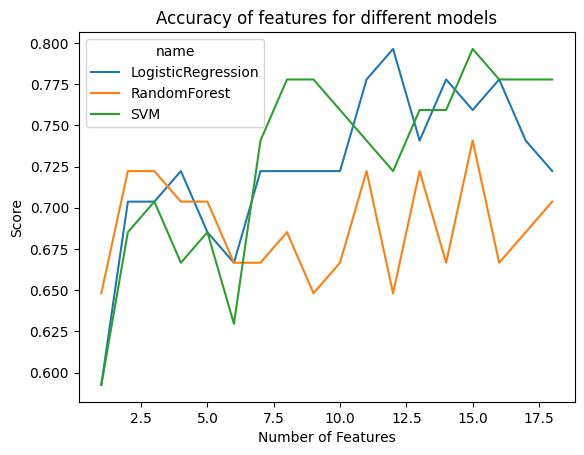

In [303]:
graphdf = pd.DataFrame.from_dict(find_best_features(models))
sns.lineplot(data=graphdf, x="n_features", y="score", hue="name")
plt.title("Accuracy of features for different models")
plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.show()

In [304]:
# find optimal features for each models
max_scores = graphdf.groupby("name")["score"].max().reset_index()
for i in range(0, len(max_scores)):
    res = graphdf[
        (graphdf["score"] == max_scores["score"][i])
        & (graphdf["name"] == max_scores["name"][i])
    ]
    print(res)

                  name  n_features     score
11  LogisticRegression          12  0.796296
            name  n_features     score
32  RandomForest          15  0.740741
   name  n_features     score
50  SVM          15  0.796296


In [305]:
pg = [
    {
        "name": "LogisticRegression",
        "estimator": LogisticRegression(),
        "params": {
            "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
            "C": [1, 2, 3, 4, 5, 10, 20, 30, 40, 50],
        },
    },
    {
        "name": "RandomForest",
        "estimator": RandomForestClassifier(),
        "params": {
            "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
            "n_jobs": [5, 10, 15, 20, 25],
        },
    },
    {
        "name": "SVM",
        "estimator": SVC(kernel="poly"),
        "params": {"C": [1, 2, 3, 4, 5, 8, 10, 20, 30], "degree": [1, 2, 3, 4]},
    },
]

In [306]:
gs_output = []
X_train.fillna(0, inplace=True)

for i in range(0, 3):
    gs = GridSearchCV(cv=3, estimator=pg[i]["estimator"], param_grid=pg[i]["params"])
    gs.fit(X_train, y_train)
    gs_output.append({"name": pg[i]["name"], "model": gs.best_estimator_})
gs_output

c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

[{'name': 'LogisticRegression', 'model': LogisticRegression(C=20)},
 {'name': 'RandomForest',
  'model': RandomForestClassifier(n_estimators=200, n_jobs=10)},
 {'name': 'SVM', 'model': SVC(C=10, degree=2, kernel='poly')}]

## Cross-Validating Models

prob needs automating... also best parameters needs to be found via gridsearch, which also needs automating...

In [307]:
def cross_val(n_arr):
    for i in range(0, len(gs_output)):
        p = Pipeline(
            [
                ("preprocessing", general_pipeline),
                ("feature_selection", SelectKBest(f_classif, k=n_arr[i])),
                ("model", gs_output[i]["model"])
            ]
        )
        res = cross_validate(p, X_train, y_train, scoring="accuracy", cv=5)
        print(f"{gs_output[i]['name']}: {np.mean(res['test_score'])}")

In [308]:
cross_val([12,15,15])

LogisticRegression: 0.6167220376522702
RandomForest: 0.7706533776301219
SVM: 0.6542635658914728


In [326]:
# RF seems better!
final_pipe = Pipeline(
    [
        ("preprocessing", general_pipeline),
        ("feature_selection", SelectKBest(f_classif, k=15)),
        ("model", RandomForestClassifier(n_estimators=200, n_jobs=10, random_state=42)),
    ]
)

final_pipe.fit(X_train, y_train)
pred = final_pipe.predict(X_test)
conf_mat = confusion_matrix(y_test, pred)
print(accuracy_score(y_test, pred))

0.7407407407407407


In [323]:
final_pipe.named_steps["feature_selection"].get_feature_names_out()

array(['x0', 'x1', 'x2', 'x4', 'x5', 'x7', 'x8', 'x9', 'x11', 'x12',
       'x13', 'x14', 'x15', 'x16', 'x18'], dtype=object)

Chosen features: Height, by, bz, ry, rz, rv, rvy, rv, ta1t, ta1x, ta1y, ta1z, pl, plr.

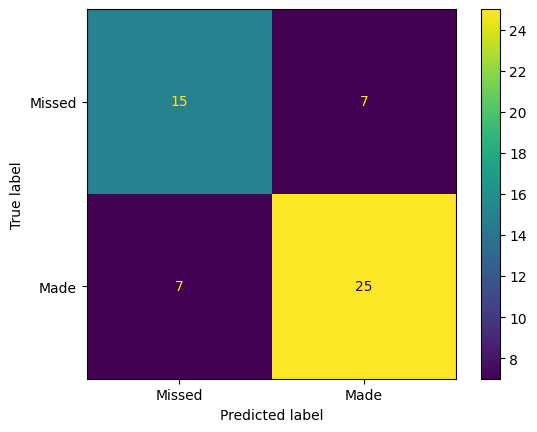

In [324]:
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=conf_mat, display_labels=["Missed", "Made"]
)
cm_display.plot()